In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn; import os; import math
from sklearn import feature_selection, linear_model, grid_search, cross_validation, metrics, ensemble, learning_curve 
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pickle
import xgboost as xgb
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Отбираем ПОСЛЕДНИЕ залоговые билеты со статусом Новый залог за последний год
sql_query = "SELECT \
       [Code] \
      ,[IssueDate] \
      ,[PartnerID] \
      ,IIF([Sex]='M',1,0) SEX \
      ,[Age] \
      ,[DayFromLastVisit] \
      ,[CreditCondition] \
      ,[LifeTimeDay] \
      ,[LombardCategoryID] \
      ,[CityID] \
      ,[SumAmountzb] \
      ,[AVGAmountzb] \
      ,[ZB] \
      ,[PercentBad] \
      ,[PercentGood] \
      ,[PercentNewBySMS] \
      ,[PercentNew] \
      ,[PercentOSN] \
      ,[PercentSkupka] \
      ,[PercentPerezalog] \
      ,[MaxBadPercentPerDay] \
      ,[AVGBadPercentPerDay] \
      ,[MinGoodPercentPerDay] \
      ,[AVGGoodPercentPerDay] \
      ,[AVGDneyZaloga] \
      ,[AVGDneySProshZB] \
      ,[AVGWeightGross] \
      ,[AVGWeightNet] \
      ,[AVGWeightNet999] \
      ,[AVGWeightNotBrilliant] \
      ,[AVGCostPerGram] \
      ,[AVGCost] \
      ,[MaxCost] \
      ,[QntTreasury] \
      ,[AVGPercentPerDay] \
      ,[MINPercentPerDay] \
      ,[MAXPercentPerDay] \
      ,[QntPromo] \
      ,[PercentPromo] \
      ,[OverPayAmount] \
      ,[PercentAmount] \
      ,[BadPercentPerDay] \
      ,[GoodPercentPerDay] \
      ,[DayDiff] \
      ,[isGoodZB] \
      ,BudetSledVisit \
  FROM [Gold585].[dbo].[LombardCommon1ZB] a\
  Where IsOSN <2 \
  and IssueDate = (Select MAX(IssueDate) From [Gold585].[dbo].[LombardCommon1ZB] b \
  where a.PartnerID = b.PartnerID and b.IssueDate < convert(datetime,'2018-06-01') and b.IsNew = 1) \
  and IssueDate > convert(datetime,'2017-01-01')"
data = pd.read_sql(sql_query,conn)

In [3]:
data[data['ZB']==1].shape

(93956, 46)

In [63]:
print(np.percentile(data['ZB'],99))

127.0


In [57]:
target.columns.values

array(['SEX', 'Age', 'DayFromLastVisit', 'LifeTimeDay', 'SumAmountzb',
       'AVGAmountzb', 'ZB', 'PercentBad', 'PercentGood',
       'PercentNewBySMS', 'PercentNew', 'PercentOSN', 'PercentSkupka',
       'PercentPerezalog', 'AVGDneyZaloga', 'AVGDneySProshZB',
       'AVGWeightGross', 'AVGCostPerGram', 'AVGPercentPerDay',
       'PercentPromo', 'CreditCondition_0', 'CreditCondition_1',
       'CreditCondition_2', 'CreditCondition_3', 'CreditCondition_4',
       'CreditCondition_5', 'CreditCondition_6', 'CreditCondition_7',
       'CreditCondition_8'], dtype=object)

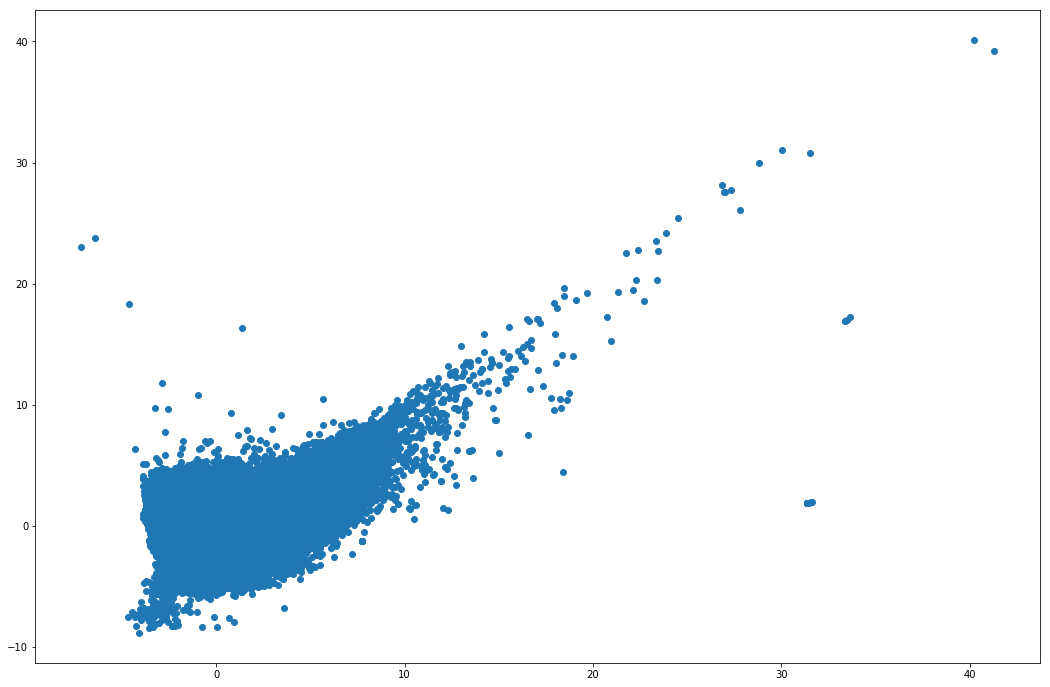

In [64]:
#df = data[((data['ZB']>1)&(data['ZB']<57))].fillna(0)
df = data.fillna(0)
df.reset_index(drop=True,inplace = True)
target=df.drop(['Code','IssueDate','CityID','PartnerID','isGoodZB','BudetSledVisit','LombardCategoryID','AVGWeightNet','AVGWeightNet999' \
                ,'AVGWeightNotBrilliant',  'AVGCost','MaxCost','QntTreasury','MAXPercentPerDay','QntPromo','OverPayAmount' \
                ,'PercentAmount','DayDiff',   'isGoodZB','BudetSledVisit','MaxBadPercentPerDay', 'AVGBadPercentPerDay',
       'MinGoodPercentPerDay', 'AVGGoodPercentPerDay', 'MINPercentPerDay','BadPercentPerDay', 'GoodPercentPerDay'], axis=1)
target = pd.get_dummies(target, columns = ['CreditCondition'])
X = StandardScaler().fit_transform(target)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

In [59]:
df.shape

(409833, 46)

In [8]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils import check_X_y
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster.unsupervised import check_number_of_labels

def silhouette_samples_memory_saving(X, labels, metric='euclidean', **kwds):
    X, labels = check_X_y(X, labels, accept_sparse=['csc', 'csr'])
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    check_number_of_labels(len(le.classes_), X.shape[0])

    unique_labels = le.classes_
    n_samples_per_label = np.bincount(labels, minlength=len(unique_labels))

    # For sample i, store the mean distance of the cluster to which
    # it belongs in intra_clust_dists[i]
    intra_clust_dists = np.zeros(X.shape[0], dtype=X.dtype)

    # For sample i, store the mean distance of the second closest
    # cluster in inter_clust_dists[i]
    inter_clust_dists = np.inf + intra_clust_dists

    for curr_label in range(len(unique_labels)):

        # Find inter_clust_dist for all samples belonging to the same
        # label.
        mask = labels == curr_label

        # Leave out current sample.
        n_samples_curr_lab = n_samples_per_label[curr_label] - 1
        if n_samples_curr_lab != 0:
            intra_distances = pairwise_distances(X[mask, :], metric=metric, **kwds)
            intra_clust_dists[mask] = np.sum(intra_distances, axis=1) / n_samples_curr_lab

        # Now iterate over all other labels, finding the mean
        # cluster distance that is closest to every sample.
        for other_label in range(len(unique_labels)):
            if other_label != curr_label:
                other_mask = labels == other_label
                inter_distances = pairwise_distances(X[mask, :], X[other_mask, :], metric=metric, **kwds)
                other_distances = np.mean(inter_distances, axis=1)
                inter_clust_dists[mask] = np.minimum(inter_clust_dists[mask], other_distances)

    sil_samples = inter_clust_dists - intra_clust_dists
    sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
    # score 0 for clusters of size 1, according to the paper
    sil_samples[n_samples_per_label.take(labels) == 1] = 0

    return np.mean(sil_samples)

In [67]:
X = pd.DataFrame(X).sample(80000)

Для 2 кластеров силуэт =  0.14045573178719348
Для 3 кластеров силуэт =  0.11415257565186714
Для 4 кластеров силуэт =  0.13316504489555808
Для 5 кластеров силуэт =  0.1394203850751121
Для 6 кластеров силуэт =  0.1448375893520442
Для 7 кластеров силуэт =  0.1683462024655598
Для 8 кластеров силуэт =  0.19902844138480652
Для 9 кластеров силуэт =  0.21681283052623404
Для 10 кластеров силуэт =  0.21676965553976937
Для 11 кластеров силуэт =  0.21075957585396177
Для 12 кластеров силуэт =  0.22334492731252004
Для 13 кластеров силуэт =  0.22828102061173577
Для 14 кластеров силуэт =  0.23004021824283755
Для 15 кластеров силуэт =  0.2386867397277345
Для 16 кластеров силуэт =  0.22397879540751478
Для 17 кластеров силуэт =  0.24377788592934063


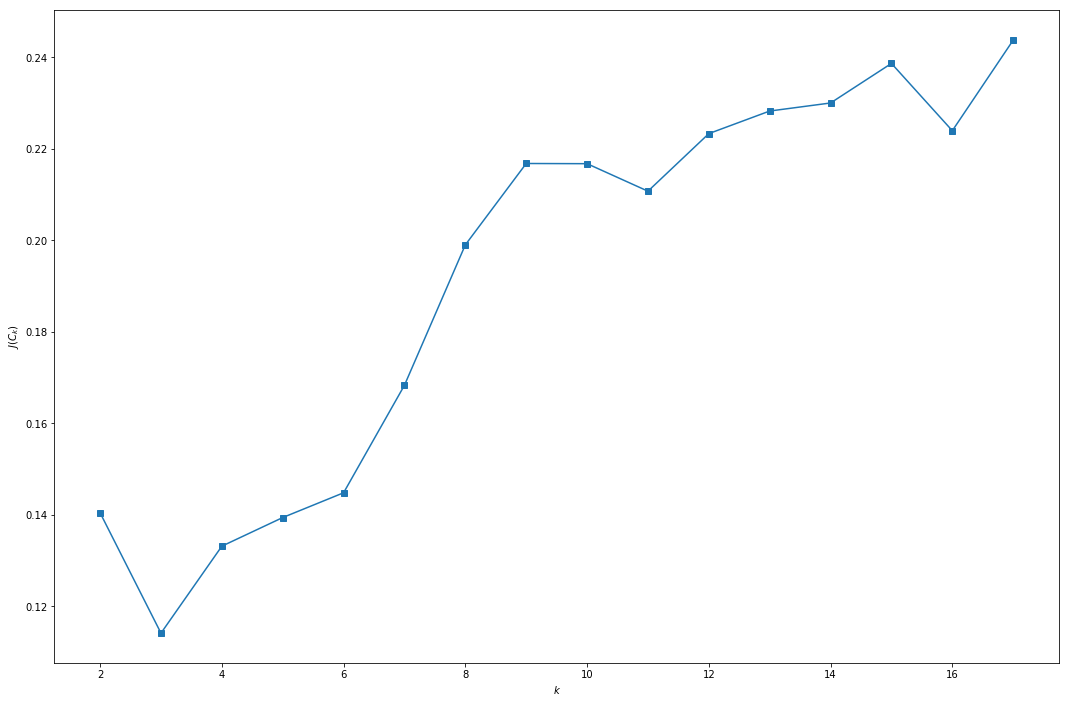

In [72]:
# 1 ЗБ
from sklearn.metrics import silhouette_score
mas = []
for k in range(2, 18):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X)
    labels = kmeans.predict(X)
    a= silhouette_samples_memory_saving(X, kmeans.labels_)
    #a= silhouette_score(X, kmeans.labels_)
    mas.append(a)
    print("Для " + str(k) + " кластеров силуэт = ", a)

plt.plot(range(2, 18), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

# Оптимальное количество кластеров 11 - 0.23

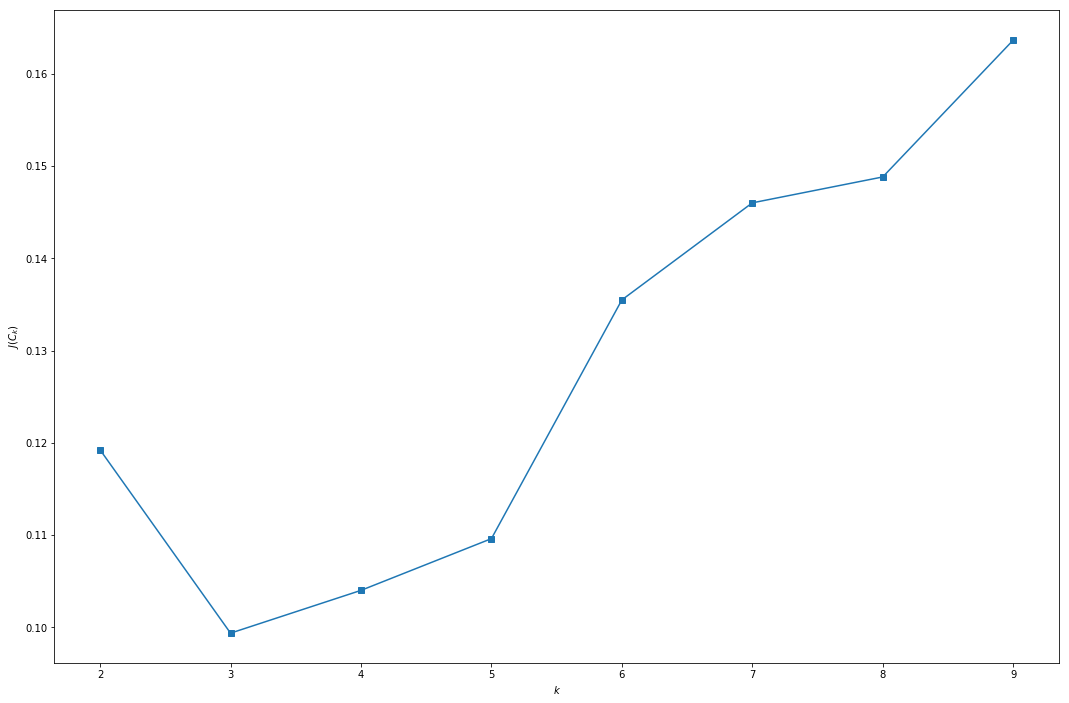

In [51]:
plt.plot(range(2, 10), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

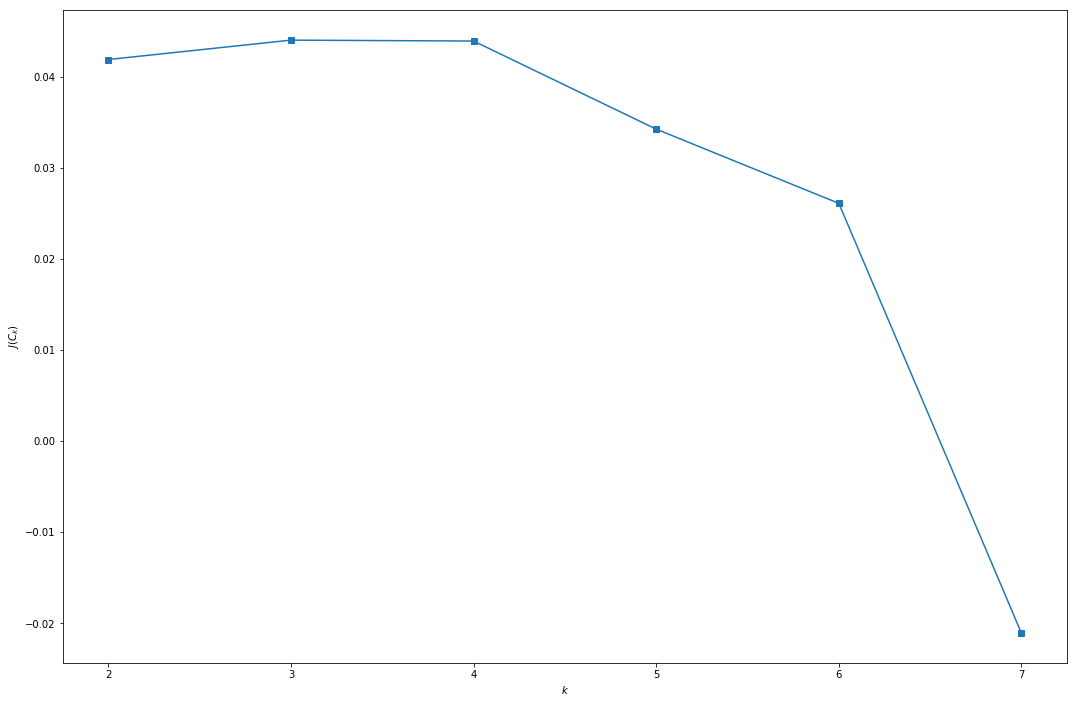

In [27]:
# 2-57 ЗБ
plt.plot(range(2, 8), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

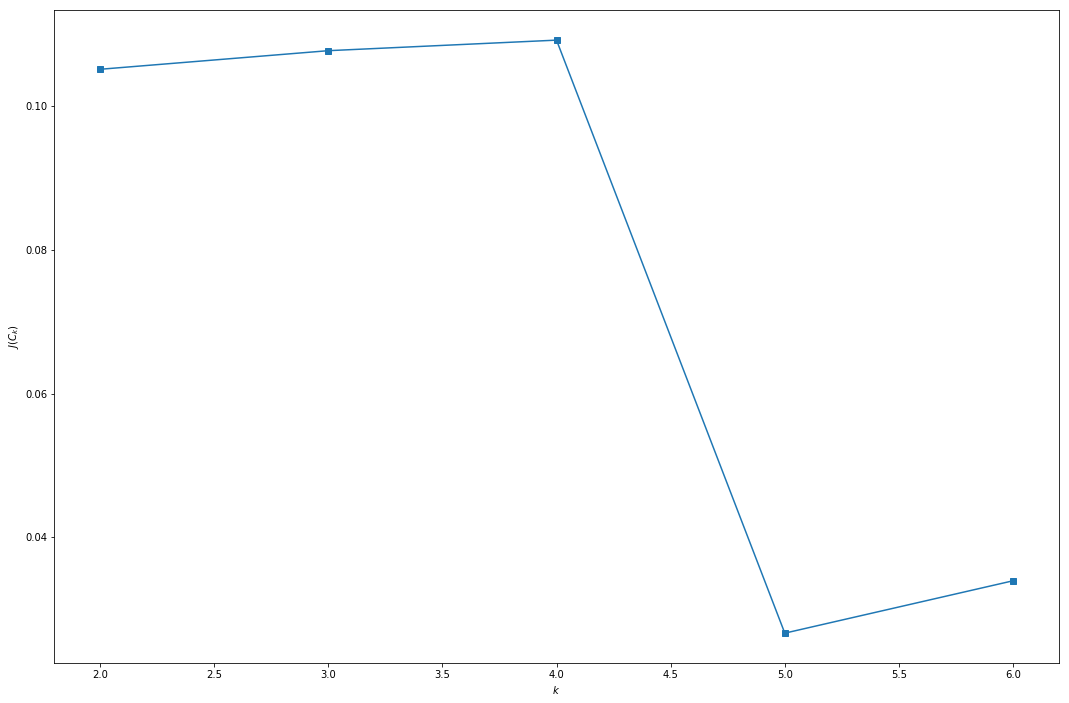

In [13]:
# 1 ЗБ - оптимальное количество кластеров 4!
plt.plot(range(2, 7), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

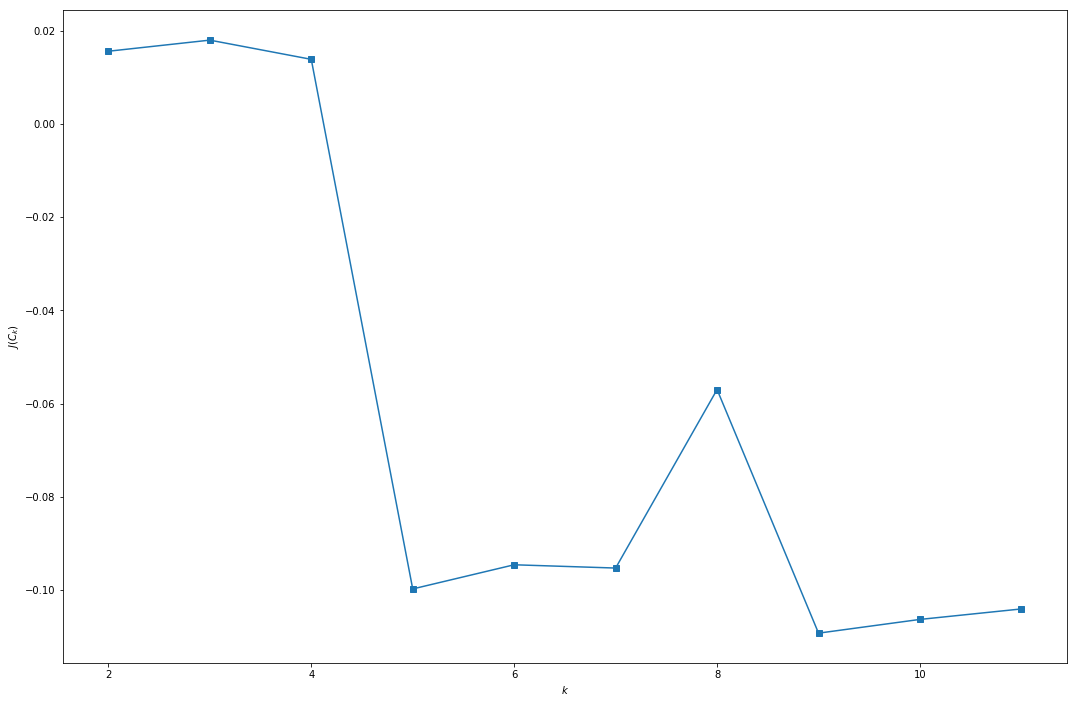

In [22]:
# от 2х до 57 ЗБ
plt.plot(range(2, 12), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

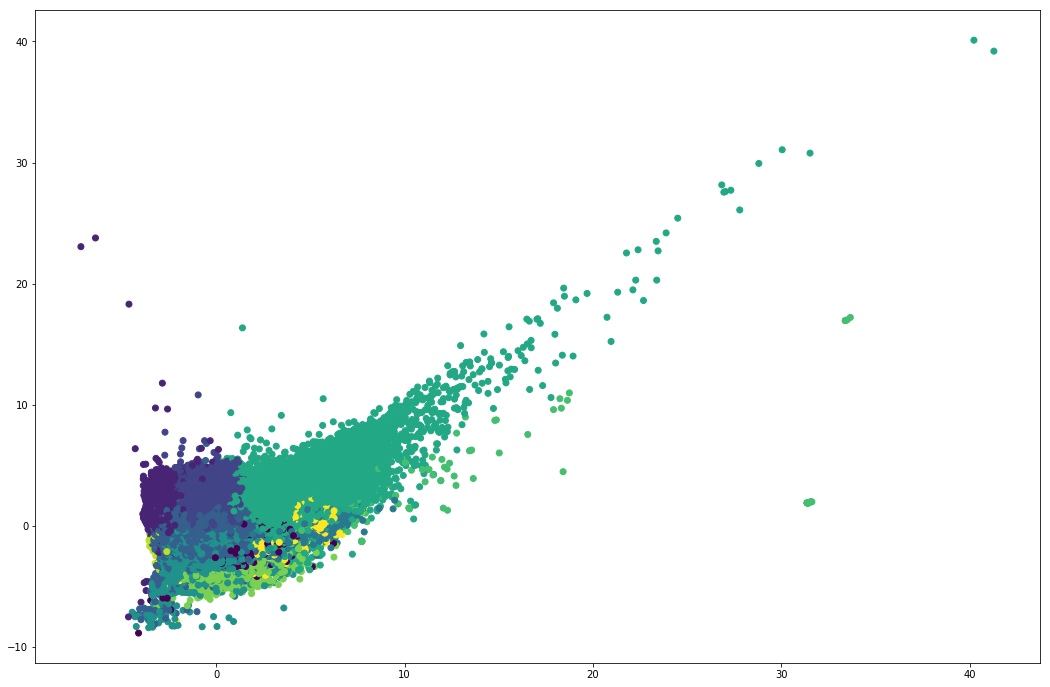

In [65]:
kmeans = KMeans(n_clusters=11, random_state=42,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [69]:
df.tail()

,Code,IssueDate,PartnerID,SEX,Age,DayFromLastVisit,CreditCondition,LifeTimeDay,LombardCategoryID,CityID,...,QntPromo,PercentPromo,OverPayAmount,PercentAmount,BadPercentPerDay,GoodPercentPerDay,DayDiff,isGoodZB,BudetSledVisit,labels
409828,630000907111,2017-11-28,5411977,0,25,297,0,297,329,112,...,0.0,0.000000,0.000000,0.0,0.0,0.33,83.0,1.0,1,2
409829,630000955013,2017-12-24,5425019,0,35,271,1,294,286,77,...,1.0,0.500000,0.000000,0.0,0.0,0.33,87.0,1.0,1,3
409830,620001451258,2017-12-08,5412376,0,69,98,0,297,175,29,...,2.0,0.181818,960.179993,0.0,0.0,1.20,220.0,6.0,1,6
409831,630000937648,2017-12-15,5515898,0,65,280,0,280,383,112,...,1.0,1.000000,0.000000,0.0,0.2,0.00,48.0,0.0,1,1
409832,620001478925,2017-12-17,5530027,0,29,278,0,278,102,92,...,1.0,1.000000,0.000000,0.0,0.0,0.15,37.0,1.0,1,2


In [70]:
print(df.shape[0])
print(df[df['labels']==0].shape[0], df[df['labels']==0].shape[0]/df.shape[0])
print(df[df['labels']==1].shape[0], df[df['labels']==1].shape[0]/df.shape[0])
print(df[df['labels']==2].shape[0], df[df['labels']==2].shape[0]/df.shape[0])
print(df[df['labels']==3].shape[0], df[df['labels']==3].shape[0]/df.shape[0])
print(df[df['labels']==4].shape[0], df[df['labels']==4].shape[0]/df.shape[0])
print(df[df['labels']==5].shape[0], df[df['labels']==5].shape[0]/df.shape[0])
print(df[df['labels']==6].shape[0], df[df['labels']==6].shape[0]/df.shape[0])
print(df[df['labels']==7].shape[0], df[df['labels']==7].shape[0]/df.shape[0])
print(df[df['labels']==8].shape[0], df[df['labels']==8].shape[0]/df.shape[0])
print(df[df['labels']==9].shape[0], df[df['labels']==9].shape[0]/df.shape[0])
print(df[df['labels']==10].shape[0], df[df['labels']==10].shape[0]/df.shape[0])

409833
31901 0.07783902223588632
60714 0.14814326811164547
75182 0.18344545217198224
65683 0.16026771880253665
28132 0.06864259344659898
76062 0.1855926682331584
40591 0.09904278084000068
1374 0.0033525850773363786
3954 0.0096478321657846
1300 0.003172023726737476
24940 0.06085405518833281


In [71]:
pd.concat([df[df['labels']==0].describe().T['50%'],df[df['labels']==0].describe().T['mean'],df[df['labels']==0].describe().T['std'], \
           df[df['labels']==1].describe().T['50%'],df[df['labels']==1].describe().T['mean'],df[df['labels']==1].describe().T['std'], \
           df[df['labels']==2].describe().T['50%'],df[df['labels']==2].describe().T['mean'],df[df['labels']==2].describe().T['std'], \
           df[df['labels']==3].describe().T['50%'],df[df['labels']==3].describe().T['mean'],df[df['labels']==3].describe().T['std'], \
           df[df['labels']==4].describe().T['50%'],df[df['labels']==4].describe().T['mean'],df[df['labels']==4].describe().T['std'], \
           df[df['labels']==5].describe().T['50%'],df[df['labels']==5].describe().T['mean'],df[df['labels']==5].describe().T['std'], \
           df[df['labels']==6].describe().T['50%'],df[df['labels']==6].describe().T['mean'],df[df['labels']==6].describe().T['std'], \
           df[df['labels']==7].describe().T['50%'],df[df['labels']==7].describe().T['mean'],df[df['labels']==7].describe().T['std'], \
           df[df['labels']==8].describe().T['50%'],df[df['labels']==8].describe().T['mean'],df[df['labels']==8].describe().T['std'], \
           df[df['labels']==9].describe().T['50%'],df[df['labels']==9].describe().T['mean'],df[df['labels']==9].describe().T['std'], \
           df[df['labels']==10].describe().T['50%'],df[df['labels']==10].describe().T['mean'],df[df['labels']==10].describe().T['std'], \
           ],axis=1).to_csv('Client-last all ZB-from 2016.csv')